# Importing Libraries

In [0]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os.path
resume_weights = "/content/drive/My Drive/checkpoint_3.pth.tar"
best_accuracy = torch.FloatTensor([0])
start_epoch = 0

# Preparing the data

In [0]:
torch.manual_seed(5)
np.random.seed(5)

In [0]:

transform= transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_trainloader = data.DataLoader(mnist_trainset, batch_size=64, shuffle=True, num_workers=2)
mnist_testset = datasets.MNIST(root='./data',train=False, download= True, transform=transform)
mnist_testloader = data.DataLoader(mnist_testset, batch_size= 64, shuffle= True, num_workers=2)


In [36]:
len(mnist_trainset)

60000

In [37]:
len(mnist_testset)

10000

In [0]:
# pytorch's tensor , tensor's 4 dimension (batch-size, no.of channels, height, width)....when looking at a particular image batch size is understood to be 1
# matplotlib wants array's dimension (height, width, channels)

# Looking at some images of dataset

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64])


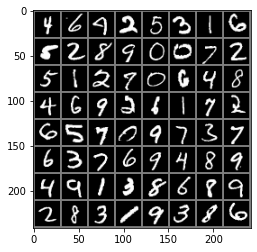

[tensor(4)][tensor(6)][tensor(4)][tensor(2)][tensor(5)][tensor(3)][tensor(1)][tensor(6)][tensor(5)][tensor(2)][tensor(8)][tensor(9)][tensor(0)][tensor(0)][tensor(7)][tensor(2)][tensor(5)][tensor(1)][tensor(2)][tensor(7)][tensor(0)][tensor(6)][tensor(4)][tensor(8)][tensor(4)][tensor(6)][tensor(9)][tensor(2)][tensor(6)][tensor(1)][tensor(7)][tensor(2)][tensor(6)][tensor(5)][tensor(7)][tensor(0)][tensor(9)][tensor(7)][tensor(3)][tensor(7)][tensor(6)][tensor(3)][tensor(7)][tensor(6)][tensor(9)][tensor(4)][tensor(8)][tensor(9)][tensor(4)][tensor(9)][tensor(1)][tensor(3)][tensor(8)][tensor(6)][tensor(8)][tensor(9)][tensor(2)][tensor(8)][tensor(3)][tensor(1)][tensor(9)][tensor(3)][tensor(8)][tensor(6)]


In [39]:
def im1show(img):
  img=img/2 + 0.5   # unnormalize
  npimg= img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

dataiter = iter(mnist_trainloader)
images, labels = dataiter.next()
print(images.size())
print(images.shape)
print(labels.size())

im1show(torchvision.utils.make_grid(images))

print(''.join('%5s' % [labels[j]] for j in range(64)))


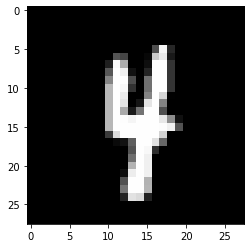

In [40]:
im1show(torchvision.utils.make_grid(images[0]))

# Another Approach

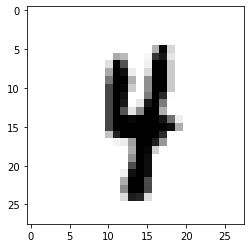

In [41]:
seed=5
torch.manual_seed(seed)
np.random.seed(seed)

dataiter = iter(mnist_trainloader)
images, labels = dataiter.next()

plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')

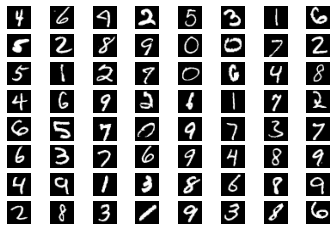

In [42]:
seed=5
torch.manual_seed(seed)
np.random.seed(seed)

dataiter = iter(mnist_trainloader)
images, labels = dataiter.next()

for i in range(64):
  plt.subplot(8,8,i+1)
  plt.axis('off')
  plt.imshow(images[i].numpy().squeeze(),cmap='gray')

# Making Model

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(1,30,5)  # no.of channels of input, no. of channels of ouptput, dimension of conv
    self.pool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(30,15,3)
    self.dropout = nn.Dropout2d(p=0.2)
    self.fc1 = nn.Linear(15*5*5,128)  # 12*12 is final dimension of image till that, 32 is no. of channel
    self.fc2 = nn.Linear(128,50)
    self.fc3 = nn.Linear(50,10)
    

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = x.view(-1, 15*5*5)    # first element is batchsize , we can use -1 as well, second element is number of features
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.log_softmax(self.fc3(x),dim=1)
    
    return x

net = Net()


# Defining Loss fn and Optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001,betas=(0.9,0.999) )

# Saving and Resuming Check Point

In [0]:
def save_checkpoint(state, is_best , file_name = "/content/drive/My Drive/checkpoint_3.pth.tar"):
  if is_best:
    print("Saving a new best")

    torch.save (state, file_name)

  else:
    print("Validation accuracy did not improve")


In [0]:
if os.path.isfile(resume_weights):
  checkpoint = torch.load(resume_weights)
  start_epoch = checkpoint['epoch']
  best_accuracy = checkpoint['best_accuracy']

  net.load_state_dict(checkpoint['state_dict'])

  print('Loaded checkpoint{} trained for{} epoch with {:.4} % test_accuracy'.format(resume_weights,
      checkpoint['epoch'],100*best_accuracy.numpy()[0]))
                                                                                 
                                                                                  

# Training the Network

In [0]:
def eval():
  net.eval

  correct = 0
  total = 0
  with torch.no_grad():
    for data in mnist_testloader:
      images,labels = data
      outputs = net(images)
      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (labels==predicted).sum().item()
  
  return 100*correct/total 



In [48]:
for epoch in range(2):

  correct = 0
  total = 0

  running_loss = 0.0
  for i, data in enumerate(mnist_trainloader,0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = torch.max(outputs,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    if i % 100 == 99:
      print('[%d , %4d] loss: %.3f  acc:%.3f %%'% 
            (epoch+1, i+1, running_loss/100, 100*correct/total))
      running_loss = 0.0

  acc_test = eval()
  acc_test = torch.FloatTensor([acc_test])
  is_best = bool(acc_test.numpy()>best_accuracy.numpy())
  best_accuracy = torch.FloatTensor(max(acc_test.numpy(),best_accuracy.numpy()))
  save_checkpoint({
      'epoch': start_epoch + epoch , 
      'state_dict': net.state_dict(), 'best_accuracy': best_accuracy}, is_best)

  print('Test_Accuracy : %.2f %%' % (
      acc_test))

print('Finished Training')

  


[1 ,  100] loss: 1.051  acc:66.734 %
[1 ,  200] loss: 0.295  acc:78.992 %
[1 ,  300] loss: 0.196  acc:84.026 %
[1 ,  400] loss: 0.171  acc:86.723 %
[1 ,  500] loss: 0.134  acc:88.619 %
[1 ,  600] loss: 0.119  acc:89.948 %
[1 ,  700] loss: 0.111  acc:90.893 %
[1 ,  800] loss: 0.087  acc:91.691 %
[1 ,  900] loss: 0.085  acc:92.318 %
Saving a new best
Test_Accuracy : 97.49 %
[2 ,  100] loss: 0.083  acc:97.391 %
[2 ,  200] loss: 0.083  acc:97.469 %
[2 ,  300] loss: 0.079  acc:97.547 %
[2 ,  400] loss: 0.075  acc:97.574 %
[2 ,  500] loss: 0.073  acc:97.619 %
[2 ,  600] loss: 0.071  acc:97.667 %
[2 ,  700] loss: 0.067  acc:97.696 %
[2 ,  800] loss: 0.062  acc:97.746 %
[2 ,  900] loss: 0.073  acc:97.764 %
Saving a new best
Test_Accuracy : 98.35 %
Finished Training


# Test the network on test data

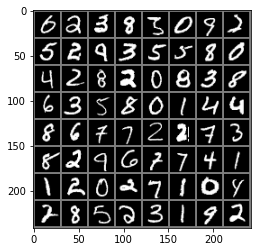

GroundTruth: tensor(6) tensor(2) tensor(3) tensor(8) tensor(3) tensor(0) tensor(9) tensor(2) tensor(5) tensor(2) tensor(9) tensor(3) tensor(5) tensor(5) tensor(8) tensor(0) tensor(4) tensor(2) tensor(8) tensor(2) tensor(0) tensor(8) tensor(3) tensor(8) tensor(6) tensor(3) tensor(5) tensor(8) tensor(0) tensor(1) tensor(4) tensor(4) tensor(8) tensor(6) tensor(7) tensor(7) tensor(2) tensor(2) tensor(7) tensor(3) tensor(8) tensor(2) tensor(9) tensor(6) tensor(7) tensor(7) tensor(4) tensor(1) tensor(1) tensor(2) tensor(0) tensor(2) tensor(7) tensor(1) tensor(0) tensor(4) tensor(2) tensor(8) tensor(5) tensor(2) tensor(3) tensor(1) tensor(9) tensor(2)


In [49]:
dataiter = iter(mnist_testloader)
images,labels = dataiter.next()

im1show(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%1s' % labels[j] for j in range(64)))

In [0]:
outputs = net(images)

In [51]:
_ , predicted = torch.max(outputs,1)

print('predicted:' , ''.join ('%2s' % predicted[j] for j in range(64)))


predicted: tensor(0)tensor(2)tensor(3)tensor(8)tensor(3)tensor(0)tensor(9)tensor(2)tensor(5)tensor(2)tensor(9)tensor(3)tensor(5)tensor(5)tensor(8)tensor(0)tensor(4)tensor(2)tensor(8)tensor(2)tensor(0)tensor(8)tensor(3)tensor(8)tensor(6)tensor(3)tensor(5)tensor(8)tensor(0)tensor(1)tensor(4)tensor(4)tensor(8)tensor(6)tensor(7)tensor(7)tensor(2)tensor(2)tensor(7)tensor(3)tensor(8)tensor(2)tensor(9)tensor(6)tensor(7)tensor(7)tensor(4)tensor(1)tensor(1)tensor(2)tensor(0)tensor(2)tensor(7)tensor(1)tensor(0)tensor(4)tensor(2)tensor(8)tensor(5)tensor(2)tensor(3)tensor(1)tensor(9)tensor(2)
